In [1]:
import os
import csv
import lightkurve as lk
from lightkurve import search_targetpixelfile
#import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import leastsq
from tqdm import tqdm
import astropy.units as u
import pylab as plt
tpf = search_targetpixelfile('249914869', mission='K2', cadence='short').download()

In [2]:
tpf

KeplerTargetPixelFile Object (ID: 249914869)

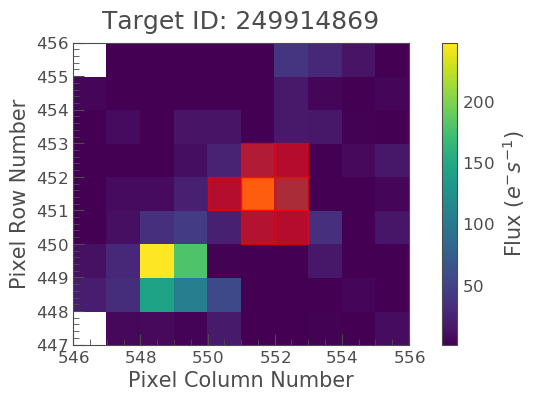

In [3]:
%matplotlib inline
tpf.plot(aperture_mask=tpf.pipeline_mask, mask_color='red')

[3156.43468779 3156.43536895 3156.43605    ... 3244.45285689 3244.45353803
 3244.45421898]
[540.7083  508.74597 520.5568  ... 498.94113 475.77777 460.54694]


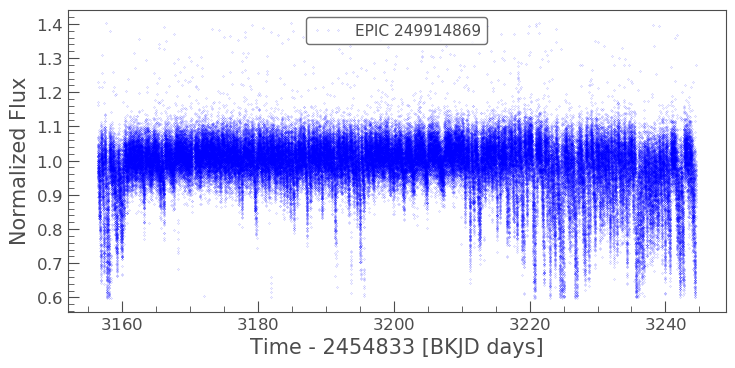

In [5]:
import matplotlib.pyplot as plt

user_lc = tpf.to_lightcurve(aperture_mask=tpf.pipeline_mask.astype(bool))
# Clean the light curve
user_lc = user_lc.remove_nans().remove_outliers()
user_lc.plot(marker='o',linestyle='None',markersize=0.1,color='blue')
#plt.ylim(0.9,1.1)
print(user_lc.time)
print(user_lc.flux)

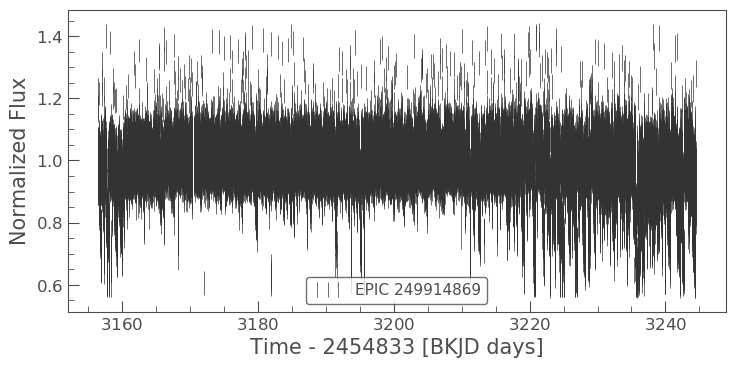

In [175]:
user_lc.errorbar();

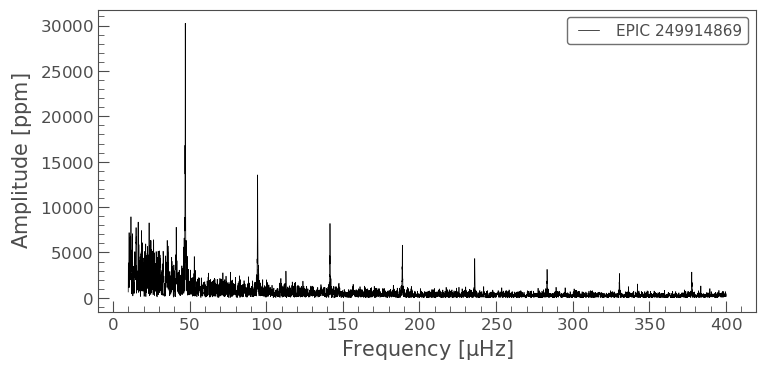

In [176]:
p = user_lc.to_periodogram(freq_unit=u.microHertz, maximum_frequency=400, minimum_frequency=10)
ax = p.plot(c='k');

/anaconda3/lib/python3.6/site-packages/lightkurve/periodogram.py:693: LightkurveWarning: As of Lightkurve v1.0.0 (Apr 2019), the default behavior of Lomb Scargle periodograms changed to use normalization='amplitude' and oversample_factor=5 (the previous defaults were normalization='psd' and oversample_factor=1). You can suppress this warning using `warnings.filterwarnings('ignore', category=lk.LightkurveWarning)`.
  LightkurveWarning)


<Quantity 0.24517842 d>

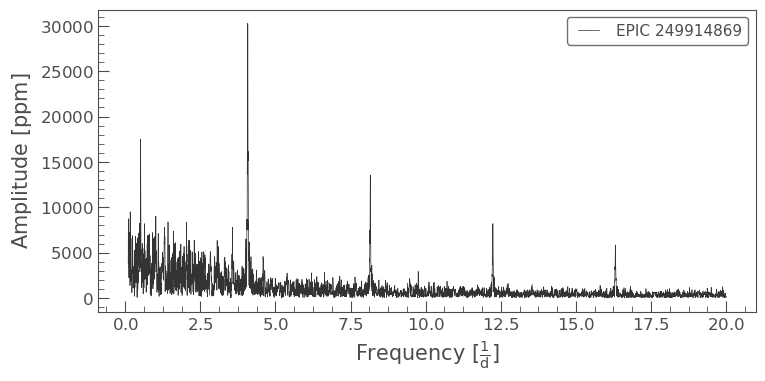

In [177]:
periodogram=lk.periodogram.LombScarglePeriodogram.from_lightcurve(user_lc, minimum_period=0.05, maximum_period =10)
periodogram.plot()
periodogram.period_at_max_power

In [ ]:
lc = tpf.to_lightcurve().normalize().remove_nans().remove_outliers()
clc = lc.correct(windows=10).remove_outliers().fill_gaps()

0.04170370190387938

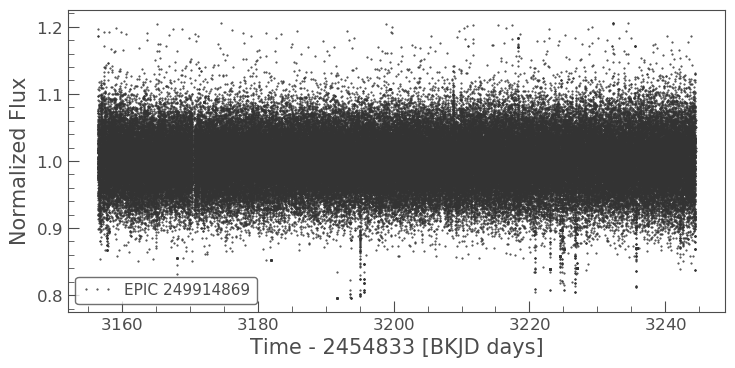

In [9]:
clc.plot(linestyle='none',marker='.')
fluxarray=clc.flux
np.std(fluxarray)

/anaconda3/lib/python3.6/site-packages/lightkurve/periodogram.py:693: LightkurveWarning: As of Lightkurve v1.0.0 (Apr 2019), the default behavior of Lomb Scargle periodograms changed to use normalization='amplitude' and oversample_factor=5 (the previous defaults were normalization='psd' and oversample_factor=1). You can suppress this warning using `warnings.filterwarnings('ignore', category=lk.LightkurveWarning)`.
  LightkurveWarning)


<Quantity 0.1025056 d>

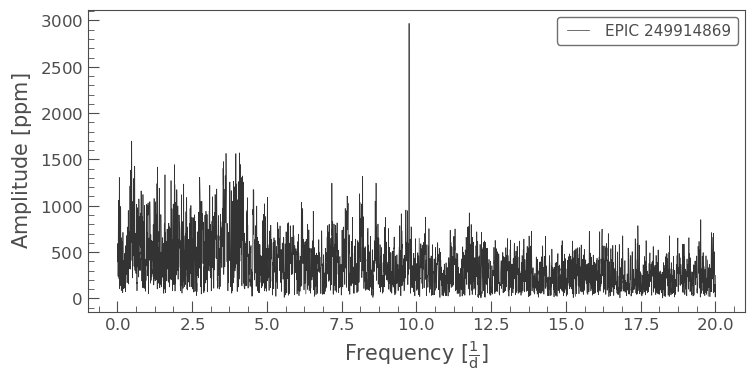

In [179]:
periodogram=lk.periodogram.LombScarglePeriodogram.from_lightcurve(clc, minimum_period=0.05, maximum_period =100)
periodogram.plot()
periodogram.period_at_max_power

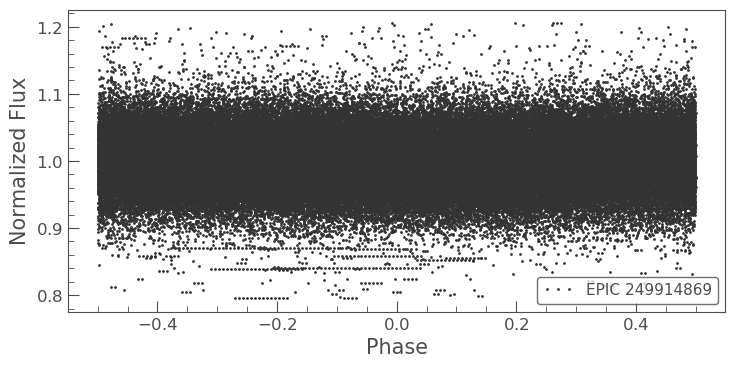

In [180]:
folded_lightcurve = clc.fold(periodogram.period_at_max_power.value)
folded_lightcurve.plot(marker='o',linestyle='none')

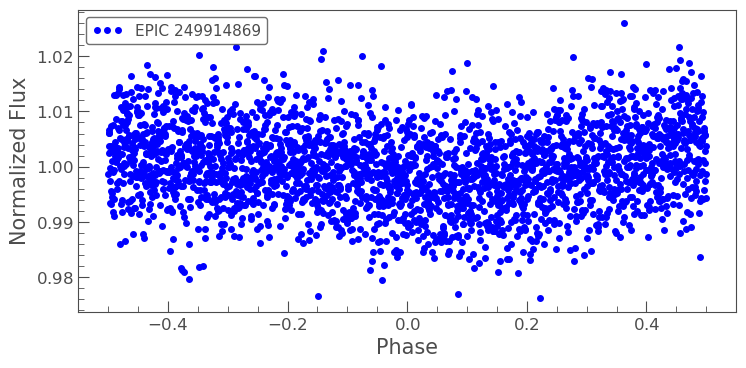

In [181]:
bin_folded_lc = folded_lightcurve.bin(50,method='median')
bin_folded_lc.plot(marker='o',linestyle='None',markersize=4,color='blue')

In [182]:
corrector=lk.SFFCorrector(lc)
new_lc = corrector.correct(lc.centroid_col,lc.centroid_row)

/anaconda3/lib/python3.6/site-packages/lightkurve/periodogram.py:693: LightkurveWarning: As of Lightkurve v1.0.0 (Apr 2019), the default behavior of Lomb Scargle periodograms changed to use normalization='amplitude' and oversample_factor=5 (the previous defaults were normalization='psd' and oversample_factor=1). You can suppress this warning using `warnings.filterwarnings('ignore', category=lk.LightkurveWarning)`.
  LightkurveWarning)


<Quantity 0.10252948 d>

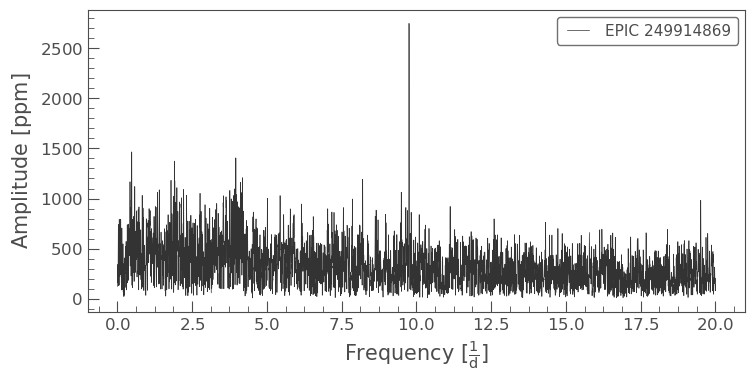

In [183]:
periodogram=lk.periodogram.LombScarglePeriodogram.from_lightcurve(new_lc, minimum_period=0.05, maximum_period =100)
periodogram.plot()
periodogram.period_at_max_power

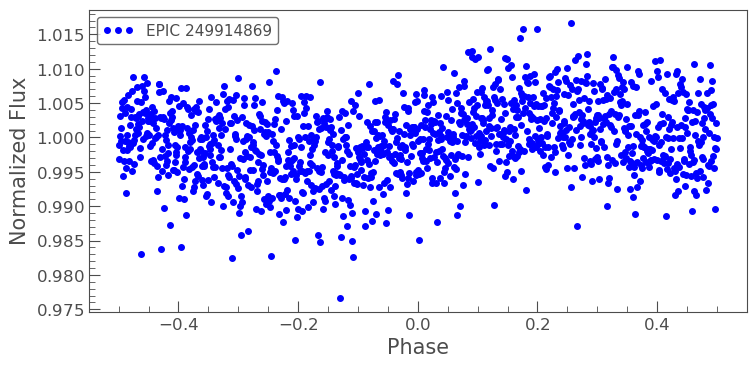

In [184]:
folded_lightcurve = new_lc.fold(periodogram.period_at_max_power.value)
bin_folded_lc = folded_lightcurve.bin(100,method='median')
bin_folded_lc.plot(marker='o',linestyle='None',markersize=4,color='blue')

0.003055106216024191


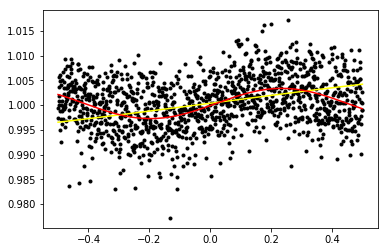

In [185]:
N = len(bin_folded_lc.flux) # number of data points
t = np.linspace(-0.5, 0.5, N)
guess_mean = np.mean(bin_folded_lc.flux)
guess_std = 3*np.std(bin_folded_lc.flux)/(2**0.5)/(2**0.5)
guess_phase = 0
guess_freq = 1
guess_amp = 1
data_first_guess = guess_std*np.sin(t+guess_phase) + guess_mean
optimize_func = lambda x: x[0]*np.sin(x[1]*t+x[2]) + x[3] - bin_folded_lc.flux
est_amp, est_freq, est_phase, est_mean = leastsq(optimize_func, [guess_amp, guess_freq, guess_phase, guess_mean])[0]
data_fit = est_amp*np.sin(est_freq*t+est_phase) + est_mean
fine_t = np.arange(-0.5,0.5,0.001)
data_fit=est_amp*np.sin(est_freq*fine_t+est_phase)+est_mean
plt.plot(t, bin_folded_lc.flux, marker='.', linestyle='none', color='black')
plt.plot(t, data_first_guess, label='first guess', color='yellow')
plt.plot(fine_t, data_fit, label='after fitting', color='red')
print(est_amp)

In [229]:
first10time=[]
second10time=[]
third10time=[]
fourth10time=[]
fifth10time=[]
sixth10time=[]
seventh10time=[]
eighth10time=[]
ninth10time=[]
first10flux=[]
second10flux=[]
third10flux=[]
fourth10flux=[]
fifth10flux=[]
sixth10flux=[]
seventh10flux=[]
eighth10flux=[]
ninth10flux=[]

counter=0

for i in user_lc.time:
    if (i>3155) and (i<3165):
        first10time.append(i)
        row=counter
        first10flux.append(user_lc.flux[row])
    if (i>3165) and (i<3175):
        second10time.append(i)
        row=counter
        second10flux.append(user_lc.flux[row])
    if (i>3175) and (i<3185):
        third10time.append(i)
        row=counter
        third10flux.append(user_lc.flux[row])
    if (i>3185) and (i<3195):
        fourth10time.append(i)
        row=counter
        fourth10flux.append(user_lc.flux[row])
    if (i>3195) and (i<3205):
        fifth10time.append(i)
        row=counter
        fifth10flux.append(user_lc.flux[row])
    if (i>3205) and (i<3215):
        sixth10time.append(i)
        row=counter
        sixth10flux.append(user_lc.flux[row])
    if (i>3215) and (i<3225):
        seventh10time.append(i)
        row=counter
        seventh10flux.append(user_lc.flux[row])
    if (i>3225) and (i<3235):
        eighth10time.append(i)
        row=counter
        eighth10flux.append(user_lc.flux[row])
    if (i>3235) and (i<3245):
        ninth10time.append(i)
        row=counter
        ninth10flux.append(user_lc.flux[row])
    counter=counter+1






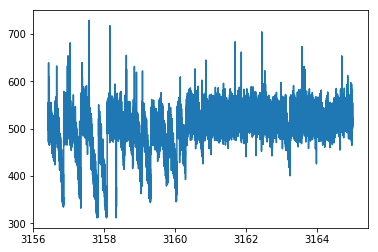

12434


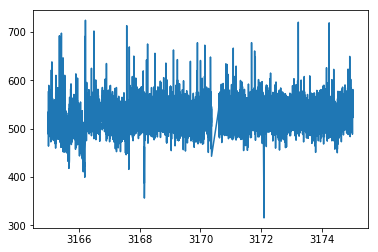

14120


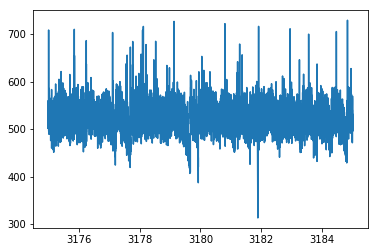

14512


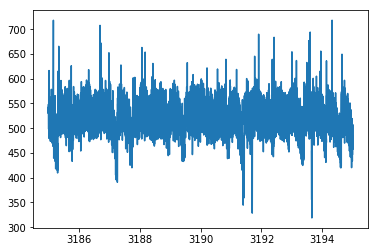

14542


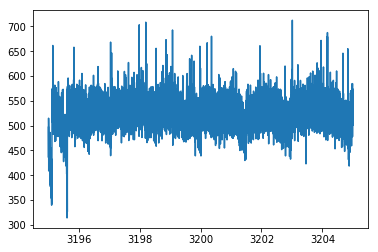

14532


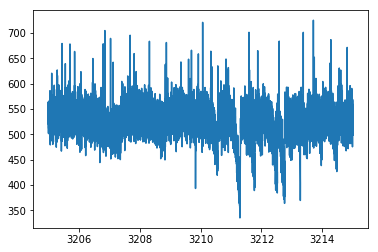

14507


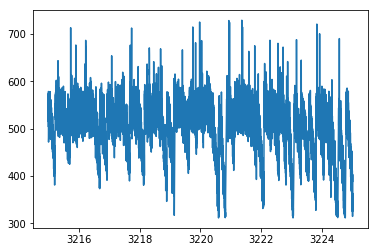

14297


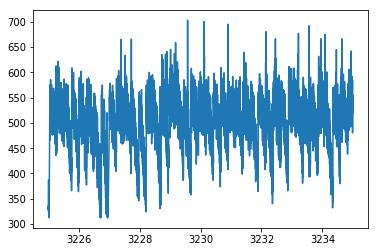

14347


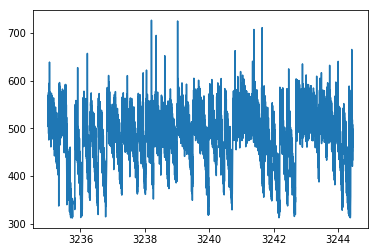

13486


In [230]:
plt.plot(first10time,first10flux)
plt.show()
print(len(first10time))

plt.plot(second10time,second10flux)
plt.show()
print(len(second10time))

plt.plot(third10time,third10flux)
plt.show()
print(len(third10time))

plt.plot(fourth10time,fourth10flux)
plt.show()
print(len(fourth10time))

plt.plot(fifth10time,fifth10flux)
plt.show()
print(len(fifth10time))

plt.plot(sixth10time,sixth10flux)
plt.show()
print(len(sixth10time))

plt.plot(seventh10time,seventh10flux)
plt.show()
print(len(seventh10time))

plt.plot(eighth10time,eighth10flux)
plt.show()
print(len(eighth10time))

plt.plot(ninth10time,ninth10flux)
plt.show()
print(len(ninth10time))

/anaconda3/lib/python3.6/site-packages/lightkurve/periodogram.py:693: LightkurveWarning: As of Lightkurve v1.0.0 (Apr 2019), the default behavior of Lomb Scargle periodograms changed to use normalization='amplitude' and oversample_factor=5 (the previous defaults were normalization='psd' and oversample_factor=1). You can suppress this warning using `warnings.filterwarnings('ignore', category=lk.LightkurveWarning)`.
  LightkurveWarning)


ValueError: operands could not be broadcast together with shapes (1241,) (125,) 

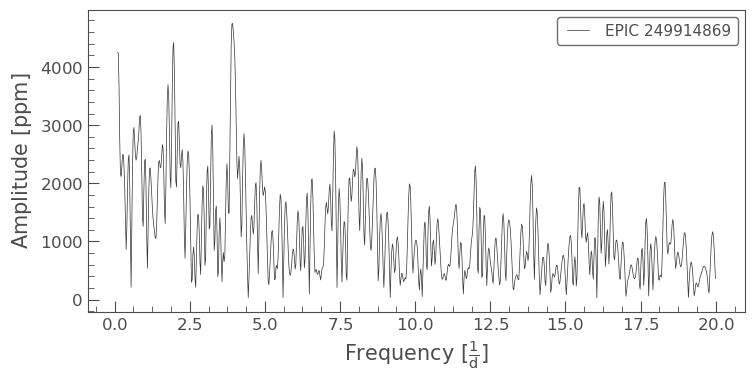

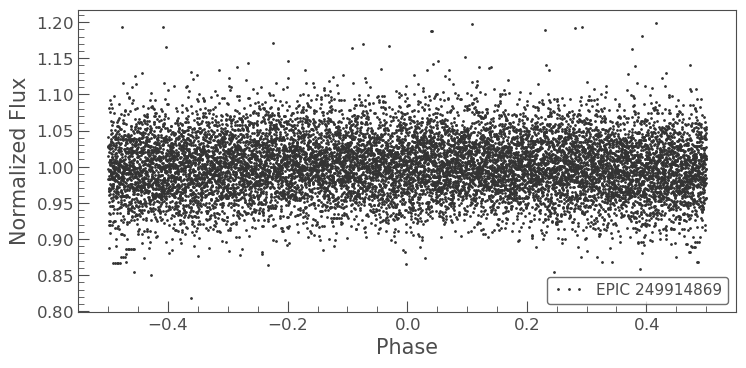

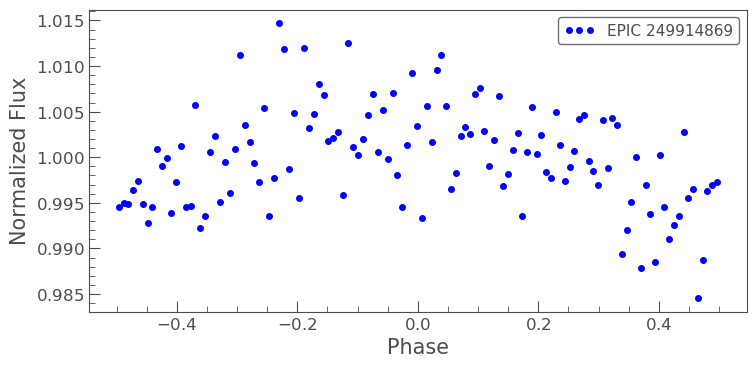

In [231]:
periodogramfirst=lk.periodogram.LombScarglePeriodogram.from_lightcurve(clc[1:12434], minimum_period=0.05, maximum_period =10)
periodogramfirst.plot()
periodogramfirst.period_at_max_power

folded_lightcurve_first = clc.fold(periodogramfirst.period_at_max_power.value)
folded_lightcurve_first.plot(marker='o',linestyle='none')

bin_folded_lc_first = folded_lightcurve_first.bin(100,method='median')
bin_folded_lc_first.plot(marker='o',linestyle='None',markersize=4,color='blue')

N_first = len(bin_folded_lc_first.flux) # number of data points
t_first = np.linspace(-0.5, 0.5, N_first)
guess_mean_first = np.mean(bin_folded_lc_first.flux)
guess_std_first = 3*np.std(bin_folded_lc_first.flux)/(2**0.5)/(2**0.5)
guess_phase_first = 0
guess_freq_first = 1
guess_amp_first = 1
data_first_guess_first = guess_std_first*np.sin(t_first+guess_phase_first) + guess_mean_first
optimize_func_first = lambda x: x[0]*np.sin(x[1]*t+x[2]) + x[3] - bin_folded_lc_first.flux
est_amp_first, est_freq_first, est_phase_first, est_mean_first = leastsq(optimize_func, [guess_amp_first, guess_freq_first, guess_phase_first, guess_mean_first])[0]
data_fit_first = est_amp_first*np.sin(est_freq_first*t_first+est_phase_first) + est_mean_first
fine_t_first = np.arange(-0.5,0.5,0.001)
data_fit_first=est_amp_first*np.sin(est_freq_first*fine_t_first+est_phase_first)+est_mean_first
plt.plot(t_first, bin_folded_lc_first.flux, marker='.', linestyle='none', color='black')
plt.plot(t_first, data_first_guess_first, label='first guess', color='yellow')
plt.plot(fine_t_first, data_fit_first, label='after fitting', color='red')
print(est_amp_first)

<Quantity 0.10212194 d>

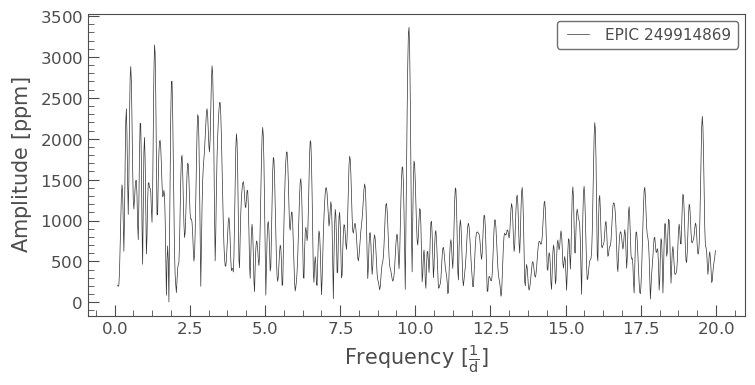

In [110]:
periodogramsecond=lk.periodogram.LombScarglePeriodogram.from_lightcurve(clc[12435:26555], minimum_period=0.05, maximum_period =10)
periodogramsecond.plot()
periodogramsecond.period_at_max_power

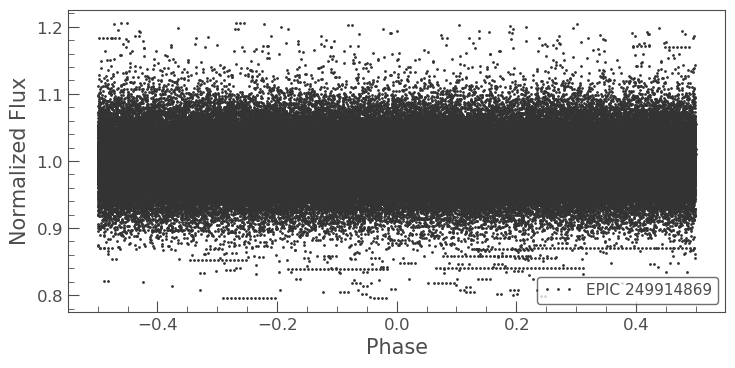

In [118]:
folded_lightcurve_second = clc.fold(periodogramsecond.period_at_max_power.value)
folded_lightcurve_second.plot(marker='o',linestyle='none')

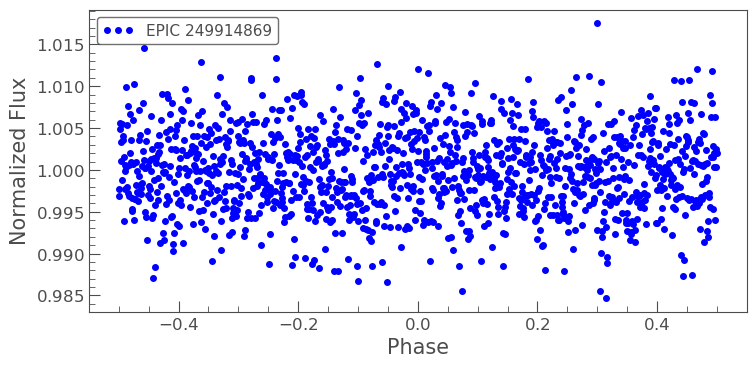

In [151]:
bin_folded_lc_second = folded_lightcurve_second.bin(100,method='median')
bin_folded_lc_second.plot(marker='o',linestyle='None',markersize=4,color='blue')

0.0030867258686343092


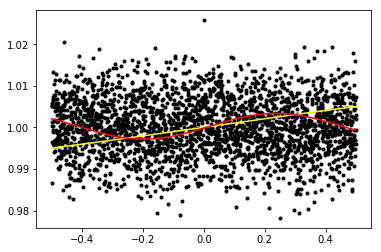

In [143]:
N_second = len(bin_folded_lc_second.flux) # number of data points
t_second = np.linspace(-0.5, 0.5, N_second)
guess_mean_second = np.mean(bin_folded_lc_second.flux)
guess_std_second = 3*np.std(bin_folded_lc_second.flux)/(2**0.5)/(2**0.5)
guess_phase_second = 0
guess_freq_second = 1
guess_amp_second = 1
data_first_guess_second = guess_std_second*np.sin(t_second+guess_phase_second) + guess_mean_second
optimize_func_second = lambda x: x[0]*np.sin(x[1]*t+x[2]) + x[3] - bin_folded_lc_second.flux
est_amp_second, est_freq_second, est_phase_second, est_mean_second = leastsq(optimize_func, [guess_amp_second, guess_freq_second, guess_phase_second, guess_mean_second])[0]
data_fit_second = est_amp_second*np.sin(est_freq_second*t_second+est_phase_second) + est_mean_second
fine_t_second = np.arange(-0.5,0.5,0.001)
data_fit_second=est_amp_second*np.sin(est_freq_second*fine_t_second+est_phase_second)+est_mean_second
plt.plot(t_second, bin_folded_lc_second.flux, marker='.', linestyle='none', color='black')
plt.plot(t_second, data_first_guess_second, label='first guess', color='yellow')
plt.plot(fine_t_second, data_fit_second, label='after fitting', color='red')
print(est_amp_second)

<Quantity 0.47615996 d>

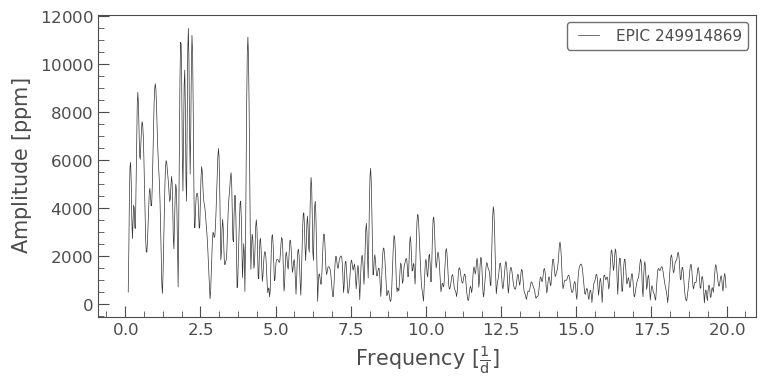

In [102]:
periodogramthird=lk.periodogram.LombScarglePeriodogram.from_lightcurve(user_lc[26556:41068], minimum_period=0.05, maximum_period =10)
periodogramthird.plot()
periodogramthird.period_at_max_power

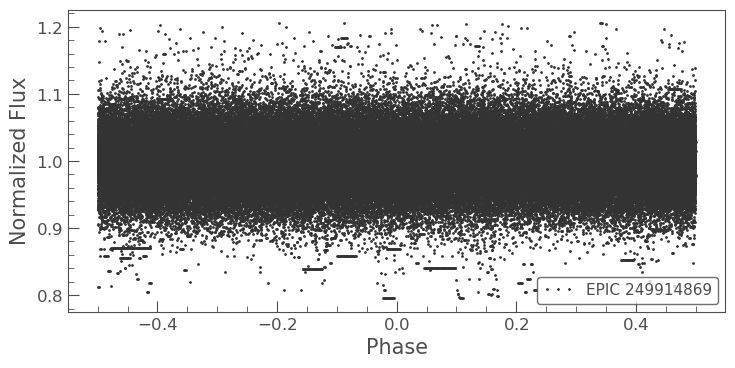

In [120]:
folded_lightcurve_third = clc.fold(periodogramthird.period_at_max_power.value)
folded_lightcurve_third.plot(marker='o',linestyle='none')

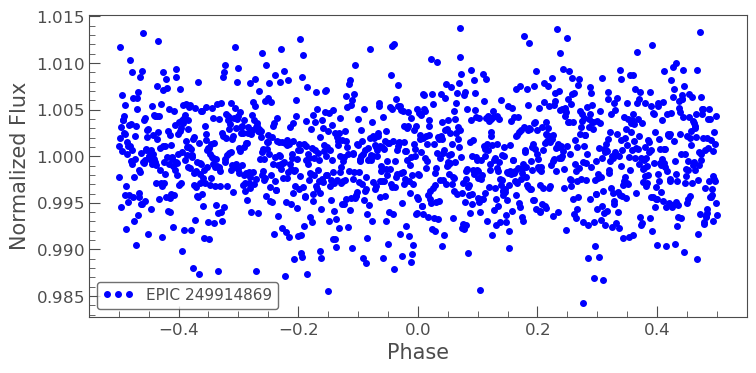

In [149]:
bin_folded_lc_third = folded_lightcurve_third.bin(100,method='median')
bin_folded_lc_third.plot(marker='o',linestyle='None',markersize=4,color='blue')

0.0030867271661538347


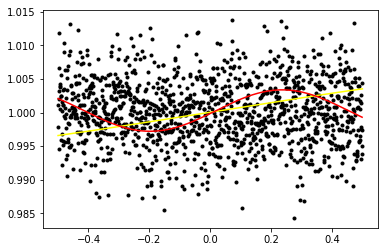

In [150]:
N_third = len(bin_folded_lc_third.flux) # number of data points
t_third = np.linspace(-0.5, 0.5, N_third)
guess_mean_third = np.mean(bin_folded_lc_third.flux)
guess_std_third = 3*np.std(bin_folded_lc_third.flux)/(2**0.5)/(2**0.5)
guess_phase_third = 0
guess_freq_third = 1
guess_amp_third = 1
data_first_guess_third= guess_std_third*np.sin(t_third+guess_phase_third) + guess_mean_third
optimize_func_third = lambda x: x[0]*np.sin(x[1]*t+x[2]) + x[3] - bin_folded_lc_third.flux
est_amp_third, est_freq_third, est_phase_third, est_mean_third = leastsq(optimize_func, [guess_amp_third, guess_freq_third, guess_phase_third, guess_mean_third])[0]
data_fit_third = est_amp_third*np.sin(est_freq_third*t_third+est_phase_third) + est_mean_third
fine_t_third = np.arange(-0.5,0.5,0.001)
data_fit_third = est_amp_third*np.sin(est_freq_third*fine_t_third+est_phase_third)+est_mean_third
plt.plot(t_third, bin_folded_lc_third.flux, marker='.', linestyle='none', color='black')
plt.plot(t_third, data_first_guess_third, label='first guess', color='yellow')
plt.plot(fine_t_third, data_fit_third, label='after fitting', color='red')
print(est_amp_third)

<Quantity 0.10240565 d>

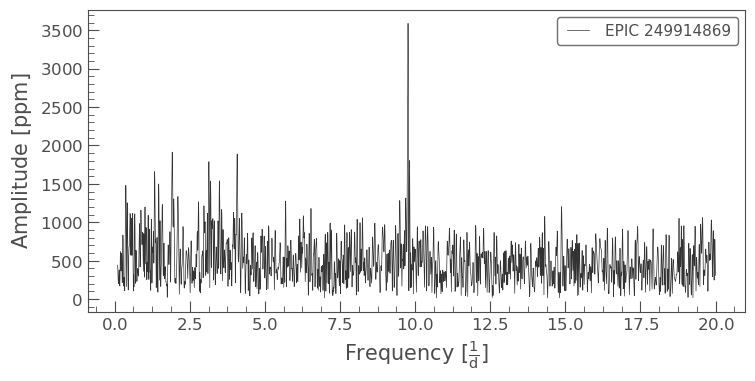

In [123]:
periodogramfourth=lk.periodogram.LombScarglePeriodogram.from_lightcurve(clc[12435:55611], minimum_period=0.05, maximum_period =10)
periodogramfourth.plot()
periodogramfourth.period_at_max_power

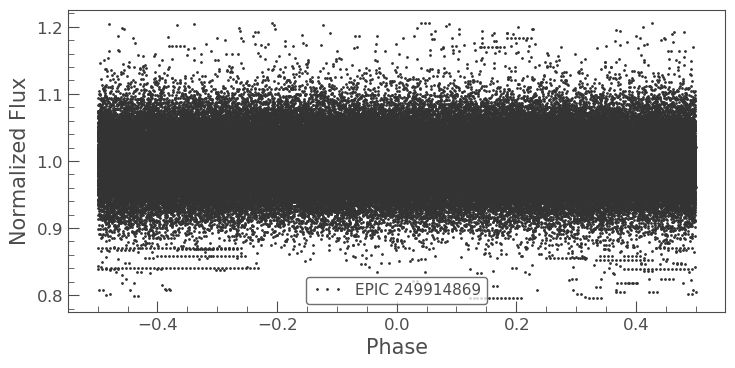

In [124]:
folded_lightcurve_fourth = clc.fold(periodogramfourth.period_at_max_power.value)
folded_lightcurve_fourth.plot(marker='o',linestyle='none')

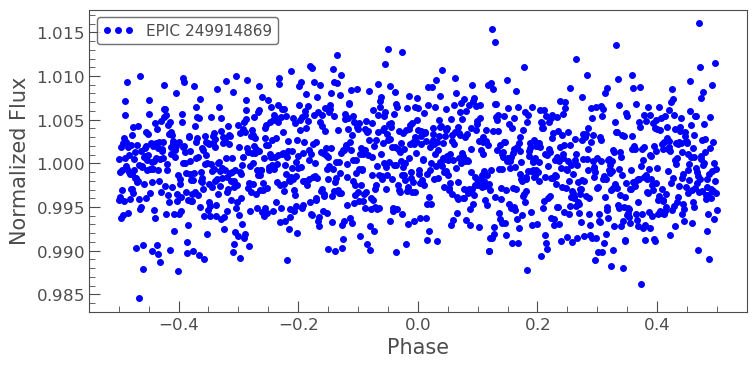

In [147]:
bin_folded_lc_fourth = folded_lightcurve_fourth.bin(100,method='median')
bin_folded_lc_fourth.plot(marker='o',linestyle='None',markersize=4,color='blue')

0.003086727435202479


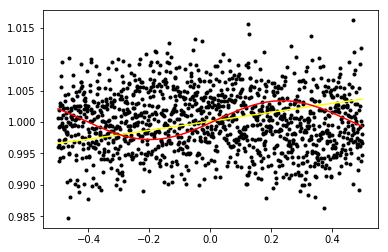

In [148]:
N_fourth = len(bin_folded_lc_fourth.flux) # number of data points
t_fourth = np.linspace(-0.5, 0.5, N_fourth)
guess_mean_fourth = np.mean(bin_folded_lc_fourth.flux)
guess_std_fourth = 3*np.std(bin_folded_lc_fourth.flux)/(2**0.5)/(2**0.5)
guess_phase_fourth = 0
guess_freq_fourth = 1
guess_amp_fourth = 1
data_first_guess_fourth= guess_std_fourth*np.sin(t_fourth+guess_phase_fourth) + guess_mean_fourth
optimize_func_fourth = lambda x: x[0]*np.sin(x[1]*t+x[2]) + x[3] - bin_folded_lc_fourth.flux
est_amp_fourth, est_freq_fourth, est_phase_fourth, est_mean_fourth = leastsq(optimize_func, [guess_amp_fourth, guess_freq_fourth, guess_phase_fourth, guess_mean_fourth])[0]
data_fit_fourth = est_amp_fourth*np.sin(est_freq_fourth*t_fourth+est_phase_fourth) + est_mean_fourth
fine_t_fourth = np.arange(-0.5,0.5,0.001)
data_fit_fourth = est_amp_fourth*np.sin(est_freq_fourth*fine_t_fourth+est_phase_fourth)+est_mean_fourth
plt.plot(t_fourth, bin_folded_lc_fourth.flux, marker='.', linestyle='none', color='black')
plt.plot(t_fourth, data_first_guess_fourth, label='first guess', color='yellow')
plt.plot(fine_t_fourth, data_fit_fourth, label='after fitting', color='red')
print(est_amp_fourth)

<Quantity 1.56240067 d>

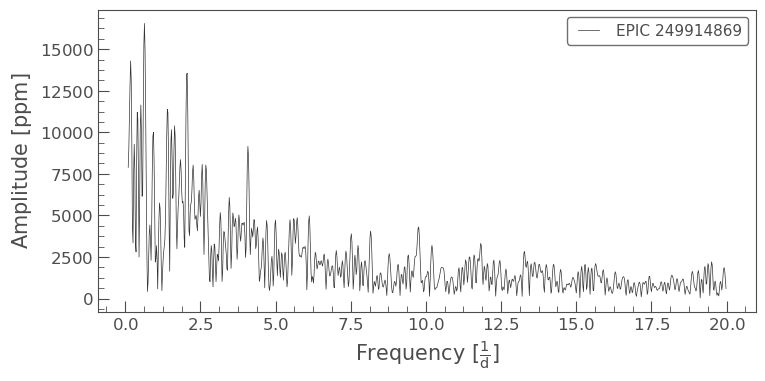

In [126]:
periodogramfifth=lk.periodogram.LombScarglePeriodogram.from_lightcurve(user_lc[55612:70144], minimum_period=0.05, maximum_period =10)
periodogramfifth.plot()
periodogramfifth.period_at_max_power

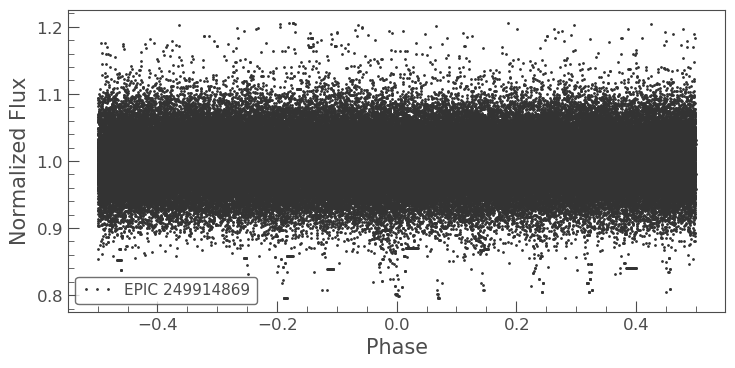

In [127]:
folded_lightcurve_fifth = clc.fold(periodogramfifth.period_at_max_power.value)
folded_lightcurve_fifth.plot(marker='o',linestyle='none')

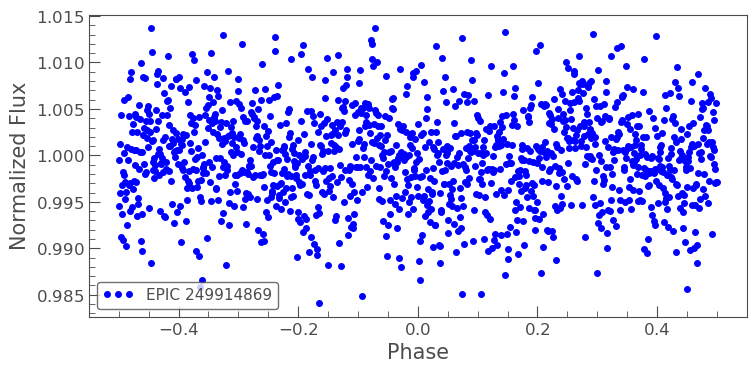

In [156]:
bin_folded_lc_fifth = folded_lightcurve_fifth.bin(100,method='median')
bin_folded_lc_fifth.plot(marker='o',linestyle='None',markersize=4,color='blue')

0.0030867258227309582


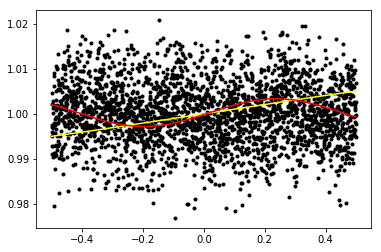

In [152]:
N_fifth = len(bin_folded_lc_fifth.flux) # number of data points
t_fifth = np.linspace(-0.5, 0.5, N_fifth)
guess_mean_fifth = np.mean(bin_folded_lc_fifth.flux)
guess_std_fifth = 3*np.std(bin_folded_lc_fifth.flux)/(2**0.5)/(2**0.5)
guess_phase_fifth = 0
guess_freq_fifth = 1
guess_amp_fifth = 1
data_first_guess_fifth= guess_std_fifth*np.sin(t_fifth+guess_phase_fifth) + guess_mean_fifth
optimize_func_fifth = lambda x: x[0]*np.sin(x[1]*t+x[2]) + x[3] - bin_folded_lc_fifth.flux
est_amp_fifth, est_freq_fifth, est_phase_fifth, est_mean_fifth = leastsq(optimize_func, [guess_amp_fifth, guess_freq_fifth, guess_phase_fifth, guess_mean_fifth])[0]
data_fit_fifth = est_amp_fifth*np.sin(est_freq_fifth*t_fifth+est_phase_fifth) + est_mean_fifth
fine_t_fifth = np.arange(-0.5,0.5,0.001)
data_fit_fifth = est_amp_fifth*np.sin(est_freq_fifth*fine_t_fifth+est_phase_fifth)+est_mean_fifth
plt.plot(t_fifth, bin_folded_lc_fifth.flux, marker='.', linestyle='none', color='black')
plt.plot(t_fifth, data_first_guess_fifth, label='first guess', color='yellow')
plt.plot(fine_t_fifth, data_fit_fifth, label='after fitting', color='red')
print(est_amp_fifth)

<Quantity 0.95104316 d>

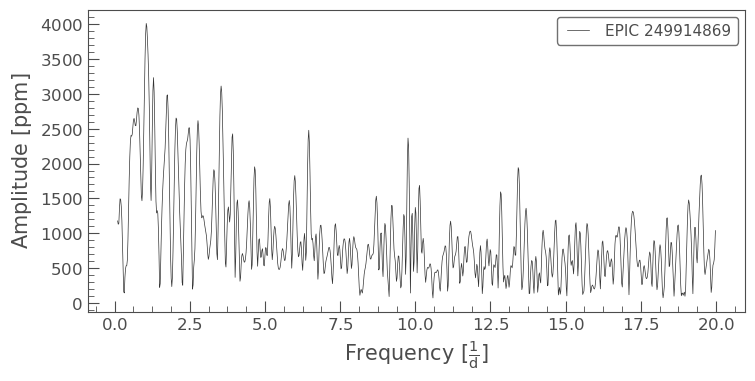

In [112]:
periodogramsixth=lk.periodogram.LombScarglePeriodogram.from_lightcurve(clc[70145:84652], minimum_period=0.05, maximum_period =10)
periodogramsixth.plot()
periodogramsixth.period_at_max_power

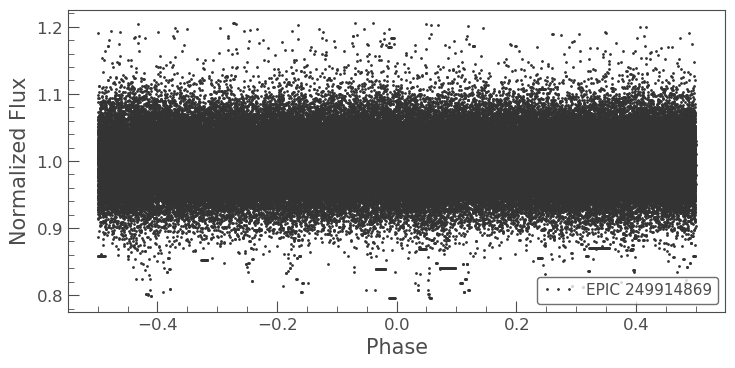

In [129]:
folded_lightcurve_sixth = clc.fold(periodogramsixth.period_at_max_power.value)
folded_lightcurve_sixth.plot(marker='o',linestyle='none')

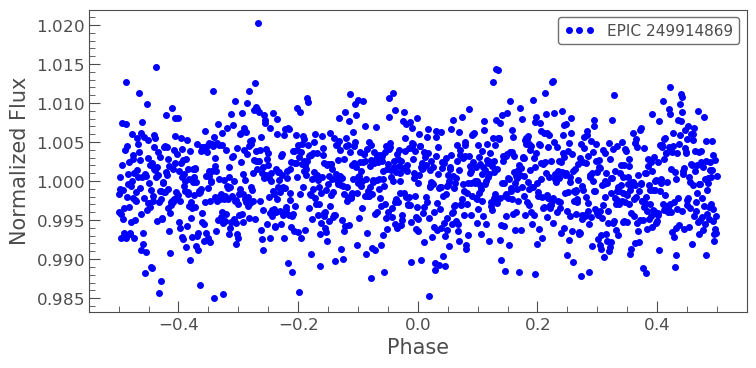

In [154]:
bin_folded_lc_sixth = folded_lightcurve_sixth.bin(100,method='median')
bin_folded_lc_sixth.plot(marker='o',linestyle='None',markersize=4,color='blue')

0.003086726443717155


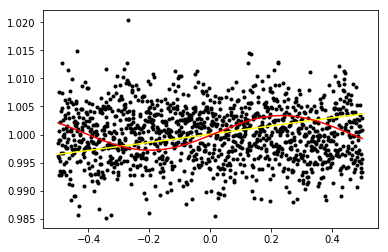

In [155]:
N_sixth = len(bin_folded_lc_sixth.flux) # number of data points
t_sixth = np.linspace(-0.5, 0.5, N_sixth)
guess_mean_sixth = np.mean(bin_folded_lc_sixth.flux)
guess_std_sixth = 3*np.std(bin_folded_lc_sixth.flux)/(2**0.5)/(2**0.5)
guess_phase_sixth = 0
guess_freq_sixth = 1
guess_amp_sixth = 1
data_first_guess_sixth= guess_std_sixth*np.sin(t_sixth+guess_phase_sixth) + guess_mean_sixth
optimize_func_sixth = lambda x: x[0]*np.sin(x[1]*t+x[2]) + x[3] - bin_folded_lc_sixth.flux
est_amp_sixth, est_freq_sixth, est_phase_sixth, est_mean_sixth = leastsq(optimize_func, [guess_amp_sixth, guess_freq_sixth, guess_phase_sixth, guess_mean_sixth])[0]
data_fit_sixth = est_amp_sixth*np.sin(est_freq_sixth*t_sixth+est_phase_sixth) + est_mean_sixth
fine_t_sixth = np.arange(-0.5,0.5,0.001)
data_fit_sixth = est_amp_sixth*np.sin(est_freq_sixth*fine_t_sixth+est_phase_sixth)+est_mean_sixth
plt.plot(t_sixth, bin_folded_lc_sixth.flux, marker='.', linestyle='none', color='black')
plt.plot(t_sixth, data_first_guess_sixth, label='first guess', color='yellow')
plt.plot(fine_t_sixth, data_fit_sixth, label='after fitting', color='red')
print(est_amp_sixth)

<Quantity 0.17089264 d>

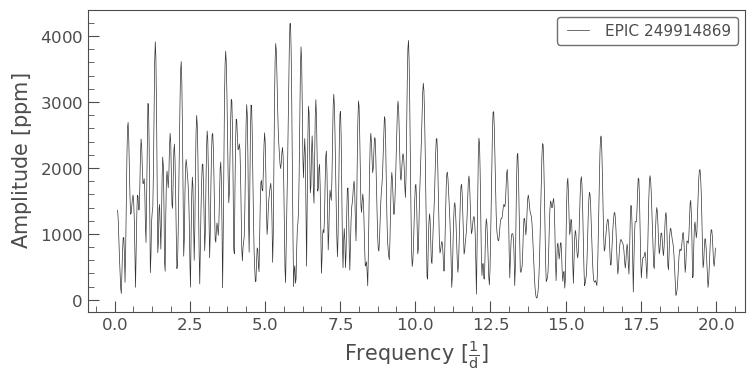

In [113]:
periodogramseventh=lk.periodogram.LombScarglePeriodogram.from_lightcurve(clc[84653:98950], minimum_period=0.05, maximum_period =10)
periodogramseventh.plot()
periodogramseventh.period_at_max_power

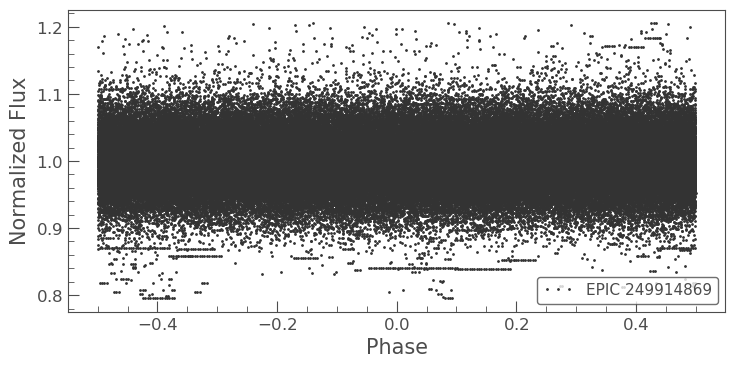

In [131]:
folded_lightcurve_seventh = clc.fold(periodogramseventh.period_at_max_power.value)
folded_lightcurve_seventh.plot(marker='o',linestyle='none')

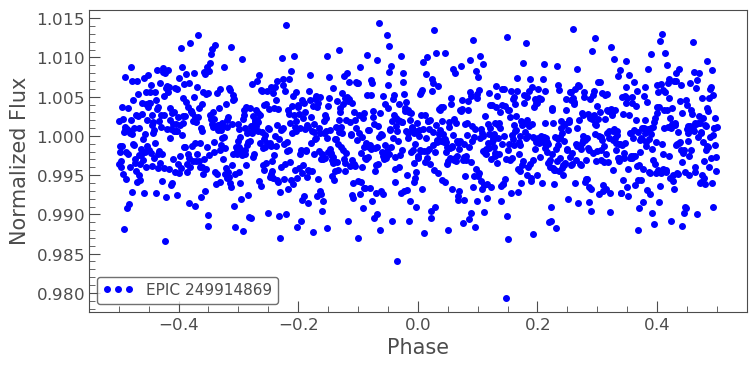

In [164]:
bin_folded_lc_seventh = folded_lightcurve_seventh.bin(100,method='median')
bin_folded_lc_seventh.plot(marker='o',linestyle='None',markersize=4,color='blue')

0.0030867319906878383


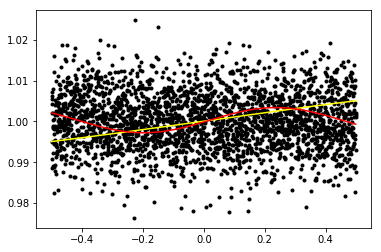

In [158]:
N_seventh = len(bin_folded_lc_seventh.flux) # number of data points
t_seventh = np.linspace(-0.5, 0.5, N_seventh)
guess_mean_seventh = np.mean(bin_folded_lc_seventh.flux)
guess_std_seventh = 3*np.std(bin_folded_lc_seventh.flux)/(2**0.5)/(2**0.5)
guess_phase_seventh = 0
guess_freq_seventh = 1
guess_amp_seventh = 1
data_first_guess_seventh= guess_std_seventh*np.sin(t_seventh+guess_phase_seventh) + guess_mean_seventh
optimize_func_seventh = lambda x: x[0]*np.sin(x[1]*t+x[2]) + x[3] - bin_folded_lc_seventh.flux
est_amp_seventh, est_freq_seventh, est_phase_seventh, est_mean_seventh = leastsq(optimize_func, [guess_amp_seventh, guess_freq_seventh, guess_phase_seventh, guess_mean_seventh])[0]
data_fit_seventh = est_amp_seventh*np.sin(est_freq_seventh*t_seventh+est_phase_seventh) + est_mean_seventh
fine_t_seventh = np.arange(-0.5,0.5,0.001)
data_fit_seventh = est_amp_seventh*np.sin(est_freq_seventh*fine_t_seventh+est_phase_seventh)+est_mean_seventh
plt.plot(t_seventh, bin_folded_lc_seventh.flux, marker='.', linestyle='none', color='black')
plt.plot(t_seventh, data_first_guess_seventh, label='first guess', color='yellow')
plt.plot(fine_t_seventh, data_fit_seventh, label='after fitting', color='red')
print(est_amp_seventh)

<Quantity 2.04529517 d>

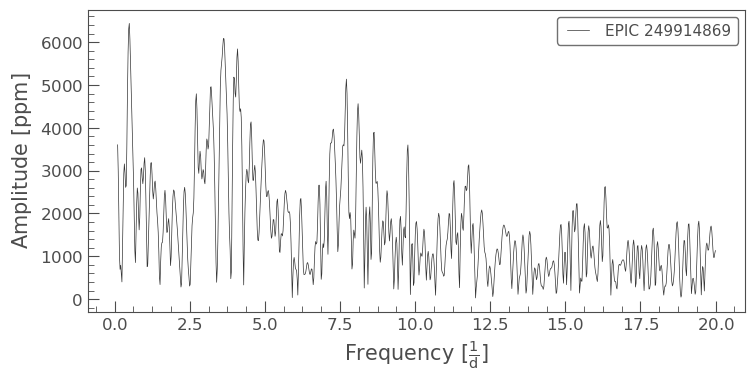

In [114]:
periodogrameighth=lk.periodogram.LombScarglePeriodogram.from_lightcurve(clc[98951:113298], minimum_period=0.05, maximum_period =10)
periodogrameighth.plot()
periodogrameighth.period_at_max_power

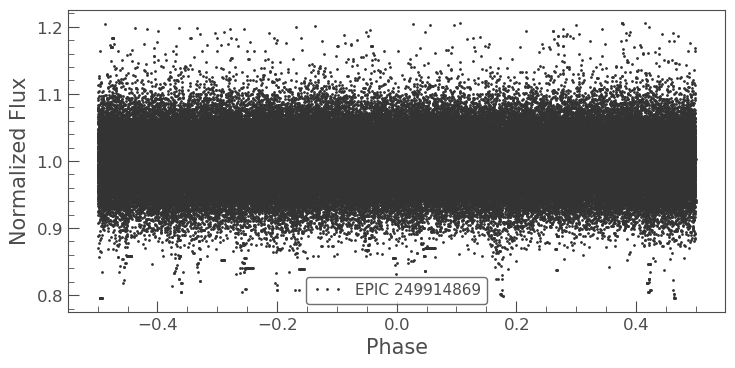

In [133]:
folded_lightcurve_eighth = clc.fold(periodogrameighth.period_at_max_power.value)
folded_lightcurve_eighth.plot(marker='o',linestyle='none')

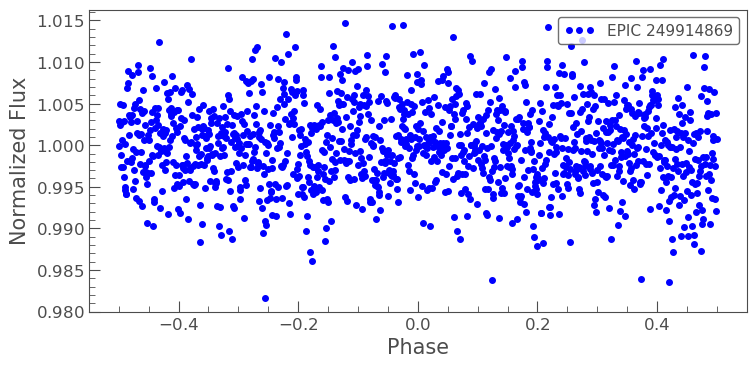

In [163]:
bin_folded_lc_eighth = folded_lightcurve_eighth.bin(100,method='median')
bin_folded_lc_eighth.plot(marker='o',linestyle='None',markersize=4,color='blue')

0.0030867277488930765


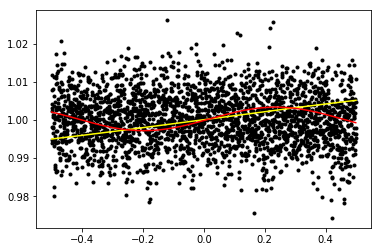

In [159]:
N_eighth = len(bin_folded_lc_eighth.flux) # number of data points
t_eighth = np.linspace(-0.5, 0.5, N_eighth)
guess_mean_eighth = np.mean(bin_folded_lc_eighth.flux)
guess_std_eighth = 3*np.std(bin_folded_lc_eighth.flux)/(2**0.5)/(2**0.5)
guess_phase_eighth = 0
guess_freq_eighth = 1
guess_amp_eighth = 1
data_first_guess_eighth= guess_std_eighth*np.sin(t_eighth+guess_phase_eighth) + guess_mean_eighth
optimize_func_eighth = lambda x: x[0]*np.sin(x[1]*t+x[2]) + x[3] - bin_folded_lc_eighth.flux
est_amp_eighth, est_freq_eighth, est_phase_eighth, est_mean_eighth = leastsq(optimize_func, [guess_amp_eighth, guess_freq_eighth, guess_phase_eighth, guess_mean_eighth])[0]
data_fit_eighth = est_amp_eighth*np.sin(est_freq_eighth*t_eighth+est_phase_eighth) + est_mean_eighth
fine_t_eighth = np.arange(-0.5,0.5,0.001)
data_fit_eighth = est_amp_eighth*np.sin(est_freq_eighth*fine_t_eighth+est_phase_eighth)+est_mean_eighth
plt.plot(t_eighth, bin_folded_lc_eighth.flux, marker='.', linestyle='none', color='black')
plt.plot(t_eighth, data_first_guess_eighth, label='first guess', color='yellow')
plt.plot(fine_t_eighth, data_fit_eighth, label='after fitting', color='red')
print(est_amp_eighth)

<Quantity 0.10250996 d>

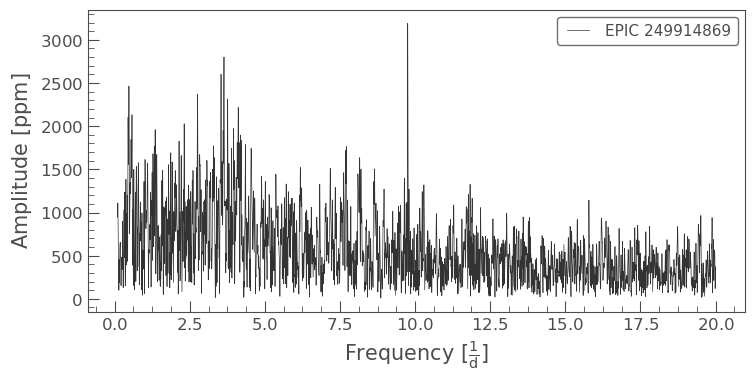

In [115]:
periodogramninth=lk.periodogram.LombScarglePeriodogram.from_lightcurve(clc[55612:126784], minimum_period=0.05, maximum_period =10)
periodogramninth.plot()
periodogramninth.period_at_max_power

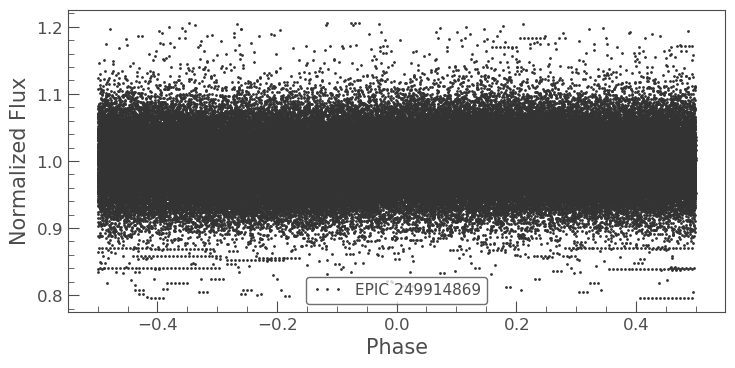

In [135]:
folded_lightcurve_ninth = clc.fold(periodogramninth.period_at_max_power.value)
folded_lightcurve_ninth.plot(marker='o',linestyle='none')

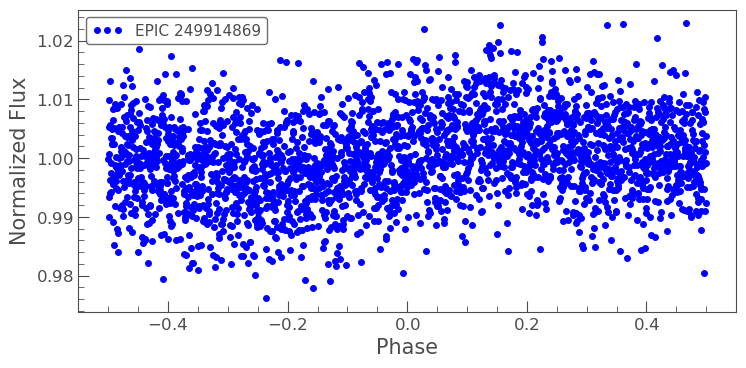

In [136]:
bin_folded_lc_ninth = folded_lightcurve_ninth.bin(50,method='median')
bin_folded_lc_ninth.plot(marker='o',linestyle='None',markersize=4,color='blue')

0.003086726827505986


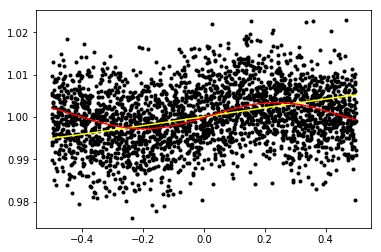

In [162]:
N_ninth = len(bin_folded_lc_ninth.flux) # number of data points
t_ninth = np.linspace(-0.5, 0.5, N_ninth)
guess_mean_ninth = np.mean(bin_folded_lc_ninth.flux)
guess_std_ninth = 3*np.std(bin_folded_lc_ninth.flux)/(2**0.5)/(2**0.5)
guess_phase_ninth = 0
guess_freq_ninth = 1
guess_amp_ninth = 1
data_first_guess_ninth= guess_std_ninth*np.sin(t_ninth+guess_phase_ninth) + guess_mean_ninth
optimize_func_ninth = lambda x: x[0]*np.sin(x[1]*t+x[2]) + x[3] - bin_folded_lc_ninth.flux
est_amp_ninth, est_freq_ninth, est_phase_ninth, est_mean_ninth = leastsq(optimize_func, [guess_amp_ninth, guess_freq_ninth, guess_phase_ninth, guess_mean_ninth])[0]
data_fit_ninth = est_amp_ninth*np.sin(est_freq_ninth*t_ninth+est_phase_ninth) + est_mean_ninth
fine_t_ninth = np.arange(-0.5,0.5,0.001)
data_fit_ninth = est_amp_ninth*np.sin(est_freq_ninth*fine_t_ninth+est_phase_ninth)+est_mean_ninth
plt.plot(t_ninth, bin_folded_lc_ninth.flux, marker='.', linestyle='none', color='black')
plt.plot(t_ninth, data_first_guess_ninth, label='first guess', color='yellow')
plt.plot(fine_t_ninth, data_fit_ninth, label='after fitting', color='red')
print(est_amp_ninth)

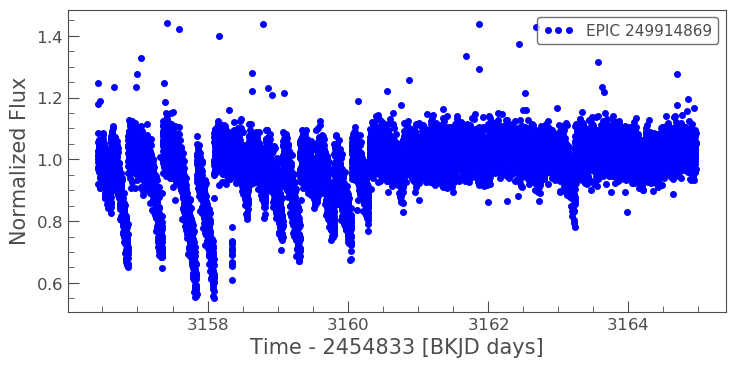

In [198]:
import matplotlib.pyplot as plt

user_lc_first = tpf.to_lightcurve(aperture_mask=tpf.pipeline_mask.astype(bool))
# Clean the light curve
user_lc_first = user_lc[1:12434].remove_nans().remove_outliers()
user_lc.plot(marker='o',linestyle='None',markersize=4,color='blue')

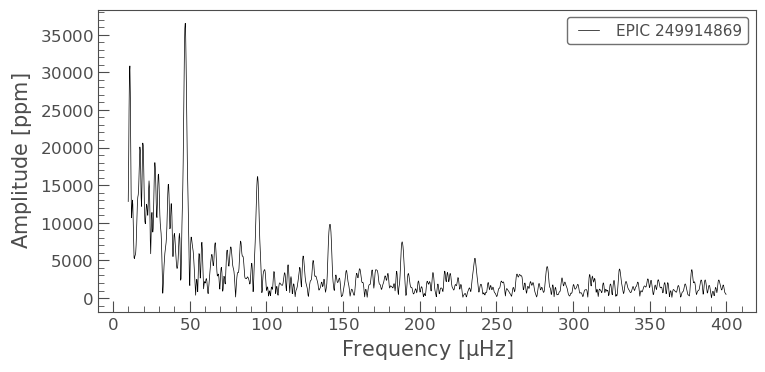

In [199]:
p = user_lc_first.to_periodogram(freq_unit=u.microHertz, maximum_frequency=400, minimum_frequency=10)
ax = p.plot(c='k');

/anaconda3/lib/python3.6/site-packages/lightkurve/periodogram.py:693: LightkurveWarning: As of Lightkurve v1.0.0 (Apr 2019), the default behavior of Lomb Scargle periodograms changed to use normalization='amplitude' and oversample_factor=5 (the previous defaults were normalization='psd' and oversample_factor=1). You can suppress this warning using `warnings.filterwarnings('ignore', category=lk.LightkurveWarning)`.
  LightkurveWarning)


<Quantity 10. d>

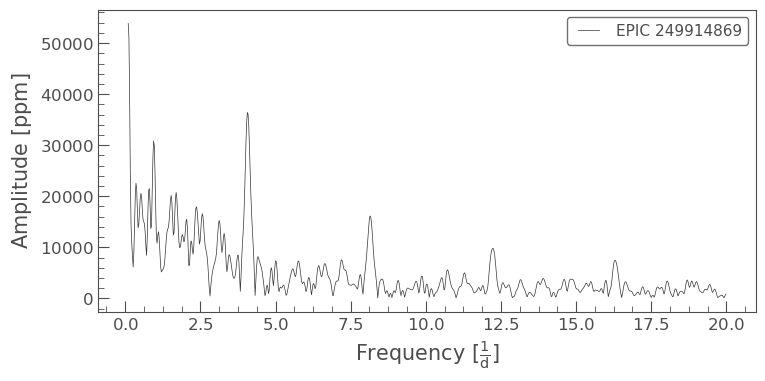

In [200]:
periodogram=lk.periodogram.LombScarglePeriodogram.from_lightcurve(user_lc_first, minimum_period=0.05, maximum_period =10)
periodogram.plot()
periodogram.period_at_max_power

/anaconda3/lib/python3.6/site-packages/lightkurve/lightcurve.py:1436: LightkurveWarning: `KeplerLightCurve.correct()` is deprecated and will be removed in Lightkurve v1.0.0, please use `LightCurve.to_corrector("sff").correct()` instead.
  LightkurveWarning)


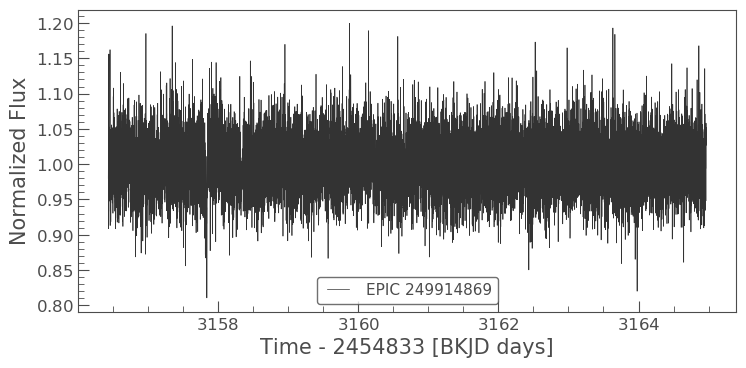

In [206]:
lc_first = tpf[1:12434].to_lightcurve().normalize().remove_nans().remove_outliers()
clc_first = lc_first.correct(windows=10).remove_outliers().fill_gaps()
clc_first.plot()

/anaconda3/lib/python3.6/site-packages/lightkurve/periodogram.py:693: LightkurveWarning: As of Lightkurve v1.0.0 (Apr 2019), the default behavior of Lomb Scargle periodograms changed to use normalization='amplitude' and oversample_factor=5 (the previous defaults were normalization='psd' and oversample_factor=1). You can suppress this warning using `warnings.filterwarnings('ignore', category=lk.LightkurveWarning)`.
  LightkurveWarning)


<Quantity 0.11543646 d>

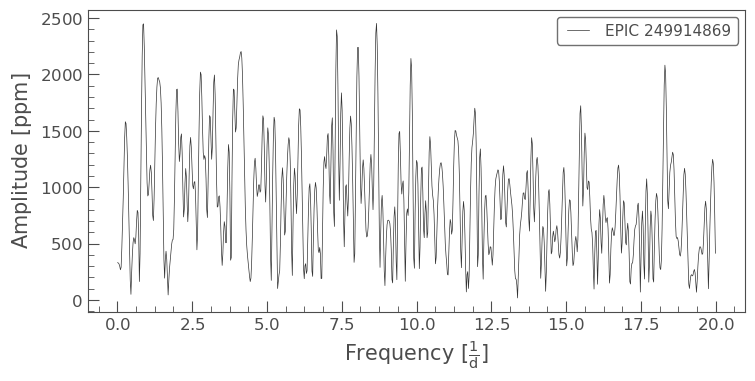

In [207]:
periodogram=lk.periodogram.LombScarglePeriodogram.from_lightcurve(clc_first, minimum_period=0.05, maximum_period =100)
periodogram.plot()
periodogram.period_at_max_power

In [216]:
folded_lightcurve = clc_first.fold(periodogram.period_at_max_power.value)
#folded_lightcurve.plot(marker='o',linestyle='none')

In [217]:
bin_folded_lc_first = folded_lightcurve.bin(10,method='median')
#bin_folded_lc_first.plot(marker='o',linestyle='None',markersize=4,color='blue')

In [211]:
corrector=lk.SFFCorrector(lc_first)
new_lc_first = corrector.correct(lc_first.centroid_col,lc_first.centroid_row)

/anaconda3/lib/python3.6/site-packages/lightkurve/periodogram.py:693: LightkurveWarning: As of Lightkurve v1.0.0 (Apr 2019), the default behavior of Lomb Scargle periodograms changed to use normalization='amplitude' and oversample_factor=5 (the previous defaults were normalization='psd' and oversample_factor=1). You can suppress this warning using `warnings.filterwarnings('ignore', category=lk.LightkurveWarning)`.
  LightkurveWarning)


<Quantity 1.13944222 d>

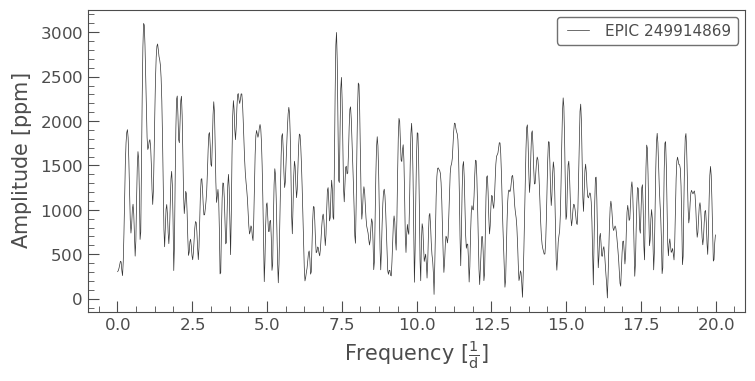

In [212]:
periodogram=lk.periodogram.LombScarglePeriodogram.from_lightcurve(new_lc_first, minimum_period=0.05, maximum_period =100)
periodogram.plot()
periodogram.period_at_max_power

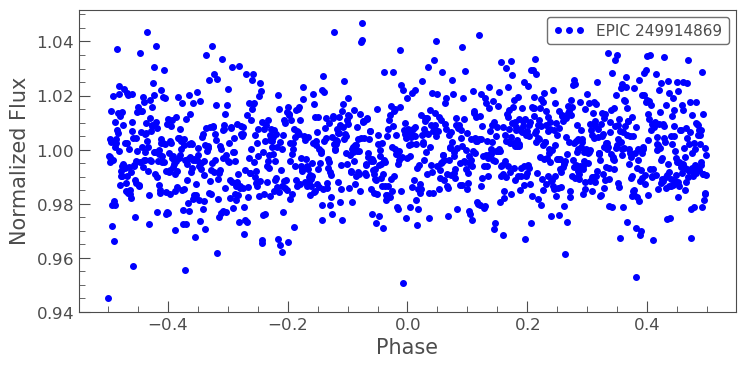

In [213]:
folded_lightcurve = new_lc_first.fold(periodogram.period_at_max_power.value)
bin_folded_lc_first = folded_lightcurve.bin(10,method='median')
bin_folded_lc_first.plot(marker='o',linestyle='None',markersize=4,color='blue')

-0.0021470396761173773


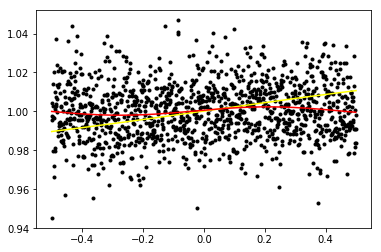

In [215]:
N = len(bin_folded_lc_first.flux) # number of data points
t = np.linspace(-0.5, 0.5, N)
guess_mean = np.mean(bin_folded_lc_first.flux)
guess_std = 3*np.std(bin_folded_lc_first.flux)/(2**0.5)/(2**0.5)
guess_phase = 0
guess_freq = 1
guess_amp = 1
data_first_guess = guess_std*np.sin(t+guess_phase) + guess_mean
optimize_func = lambda x: x[0]*np.sin(x[1]*t+x[2]) + x[3] - bin_folded_lc_first.flux
est_amp, est_freq, est_phase, est_mean = leastsq(optimize_func, [guess_amp, guess_freq, guess_phase, guess_mean])[0]
data_fit = est_amp*np.sin(est_freq*t+est_phase) + est_mean
fine_t = np.arange(-0.5,0.5,0.001)
data_fit=est_amp*np.sin(est_freq*fine_t+est_phase)+est_mean
plt.plot(t, bin_folded_lc_first.flux, marker='.', linestyle='none', color='black')
plt.plot(t, data_first_guess, label='first guess', color='yellow')
plt.plot(fine_t, data_fit, label='after fitting', color='red')
print(est_amp)